In [1]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math

In [2]:
nVelocity = 401
minx = -100
maxx = 100
velocityArray = np.linspace(minx,maxx,nVelocity)

In [3]:
observer_angle = 0
vel_eq = 10
mc_values = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]
training_profiles_to_generate = len(mc_values)

In [4]:
# definition of the gaussian profile
def gaussian_fct(x, amp, cen, sigma):
    return amp*(np.exp((-1.0/2.0)*(((x-cen)/sigma)**2)))

# velocity shift
def shift_profile_velocity(x, y, velocity):
    shift = velocity
    xshifted = x + shift
    yshifted = np.interp(x, xshifted, y)
    return yshifted

# limb darkening
def limb_dark(eps,radius):
    ld = 1.0 - eps + eps*np.cos(np.arcsin(radius))
    return ld

# projected rotational velocity
def proj_vel(vel_eq, x_comp, observer_angle):
    pv = vel_eq * x_comp * np.cos(np.radians(observer_angle))
    return pv

# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(24)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

In [5]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for mc_value in mc_values:
    x_p = 5
    y_p = 5
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

oot_flux_profiles = np.squeeze(intensities_list)

Time to generate 20 training profiles: 0.11 hours


In [6]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for mc_value in mc_values:
    x_p = 0
    y_p = 0
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles = np.squeeze(intensities_list)

Time to generate 20 training profiles: 0.11 hours


In [7]:
print(np.shape(oot_flux_profiles))
print(np.shape(flux_profiles))

(20, 401)
(20, 401)


In [8]:
print((flux_profiles.shape[0], 0))

(20, 0)


In [9]:
oots_profiles = flux_profiles - oot_flux_profiles

In [10]:
# Normalize the mc_values to be between 0 and 1
norm = mcolors.Normalize(vmin=min(mc_values), vmax=max(mc_values))
cmap = cm.viridis  # Choose a colormap

In [11]:
barlabelsize=18
figsize=(10, 6)
labelsize=20
legendsize=19
linesize=3
ticksize=14
titlesize=23

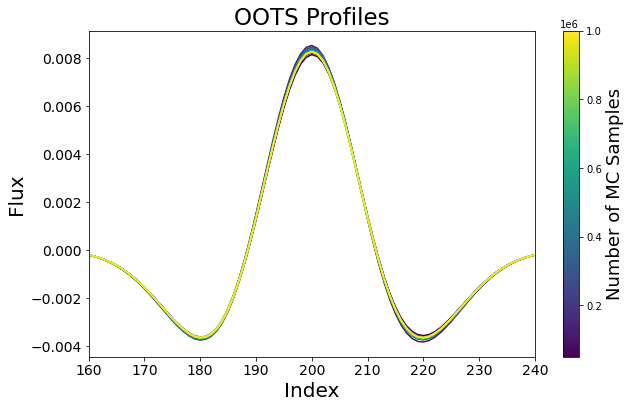

In [12]:
plt.figure(figsize=figsize)
for i in range(oots_profiles.shape[0]):
    plt.plot(oots_profiles[i], color=cmap(norm(mc_values[i])))
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlim(160, 240)
plt.xlabel('Index', fontsize=labelsize)
plt.ylabel('Flux', fontsize=labelsize)
plt.title('OOTS Profiles', fontsize=titlesize)
# Create a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Number of MC Samples', fontsize=barlabelsize)
plt.savefig("fig_1.png")
plt.show()

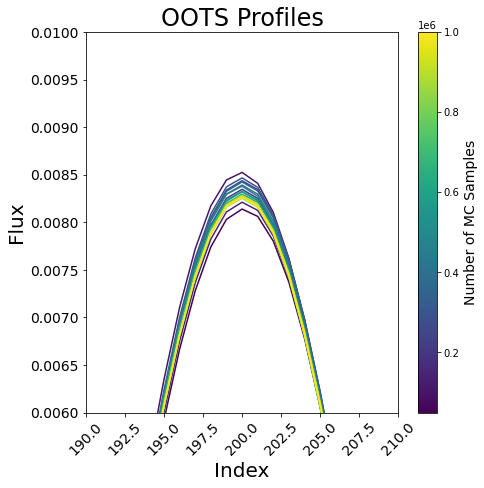

In [13]:
figsize=(7, 7)
labelsize=20
legendsize=19
linesize=3
ticksize=14
titlesize=24

plt.figure(figsize=figsize)
for i in range(oots_profiles.shape[0]):
    plt.plot(oots_profiles[i], color=cmap(norm(mc_values[i])))
#plt.ylim(0.3, 0.5)
plt.xticks(fontsize=ticksize, rotation=45)
plt.yticks(fontsize=ticksize)
plt.xlim(190, 210)
plt.ylim(0.006, 0.010)
plt.xlabel('Index', fontsize=labelsize)
plt.ylabel('Flux', fontsize=labelsize)
plt.title('OOTS Profiles', fontsize=titlesize)
# Create a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Number of MC Samples', fontsize=14)
plt.savefig("fig_2.png")
plt.show()

In [14]:
# Initialize lists to store convergence metrics
mse_values = []
max_diff_values = []

# Function to compute Mean Squared Error
def mean_squared_error(profile1, profile2):
    return np.mean((profile1 - profile2) ** 2)

# Function to compute Maximum Absolute Difference
def maximum_absolute_difference(profile1, profile2):
    return np.max(np.abs(profile1 - profile2))

# Calculate the convergence metrics for successive profiles
for i in range(len(oots_profiles) - 1):
    mse = mean_squared_error(oots_profiles[i], oots_profiles[i+1])
    max_diff = maximum_absolute_difference(oots_profiles[i], oots_profiles[i+1])
    mse_values.append(mse)
    max_diff_values.append(max_diff)

# Print metrics to check values
print("MSE values: ", mse_values)
print("Max Absolute Difference values: ", max_diff_values)

MSE values:  [8.153435710268938e-09, 5.404035798316722e-09, 8.816769243813899e-10, 3.7010512303604996e-10, 7.963132742556242e-11, 8.938852558951096e-11, 4.445474247061641e-11, 2.5048725231646237e-10, 6.944249127760012e-10, 1.6837325098157114e-10, 3.0039929720358695e-10, 3.22465815406571e-10, 9.644342533617416e-11, 3.2511161452703734e-10, 4.567380423654591e-12, 1.551943613412137e-11, 9.224591972676158e-11, 1.3505408101739663e-11, 6.064087543739464e-11]
Max Absolute Difference values:  [0.0004409484936134245, 0.0003566148459213103, 0.00014911098789271993, 9.435941534197134e-05, 4.310956849973291e-05, 5.000990918158088e-05, 3.5008554705284745e-05, 6.53474571205015e-05, 0.00011619154205355642, 5.246276733938959e-05, 7.568629331133891e-05, 7.624334269895616e-05, 3.9111209900744015e-05, 7.693596999402974e-05, 1.050144678527154e-05, 1.582418225565263e-05, 3.879864458844473e-05, 1.8782500655567524e-05, 3.15023178403262e-05]


In [15]:
figsize=(14, 6)
labelsize=20
legendsize=19
linesize=3
ticksize=14
titlesize=24

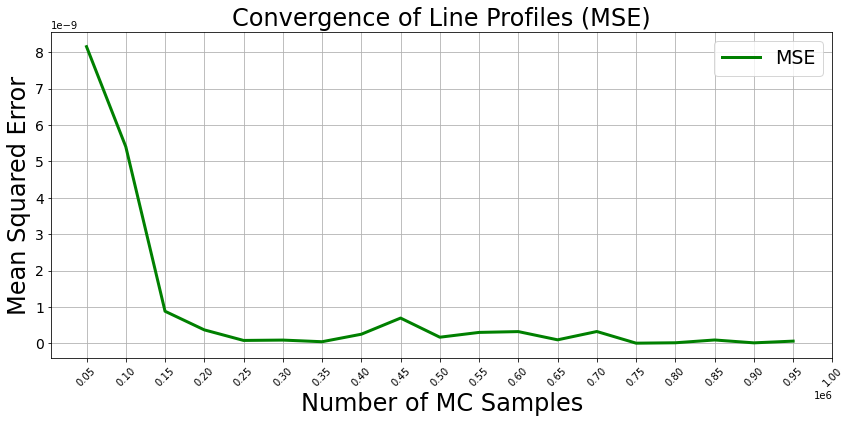

In [16]:
# Convert mc_values to match the length of the metrics
mc_values_short = mc_values[:-1]

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=figsize)
plt.plot(mc_values_short, mse_values, label='MSE', linewidth=linesize, color='Green')
plt.xticks(mc_values, rotation=45)
plt.yticks(fontsize=ticksize)
plt.xlabel('Number of MC Samples', fontsize=titlesize)
plt.ylabel('Mean Squared Error', fontsize=titlesize)
plt.title('Convergence of Line Profiles (MSE)', fontsize=titlesize)
plt.legend(fontsize=legendsize)
plt.grid(True)
plt.savefig("fig_3.png")
plt.show()

In [18]:
# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(None)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

In [19]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1000):
    x_p = 0
    y_p = 0
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 600000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles = np.squeeze(intensities_list)

Time to generate 20 training profiles: 6.43 hours


In [0]:
np.save('flux_profiles.npy', intensities_array)
loaded_flux_profiles = np.load('flux_profiles.npy')

In [27]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1):
    x_p = 5
    y_p = 5
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 600000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

new_oot_flux_profile = np.squeeze(intensities_list)

Time to generate 20 training profiles: 0.01 hours


In [28]:
print(len(loaded_flux_profiles))
new_oots_profiles = loaded_flux_profiles - np.tile(new_oot_flux_profile, (loaded_flux_profiles.shape[0], 1))
print(len(new_oots_profiles))

1000
1000


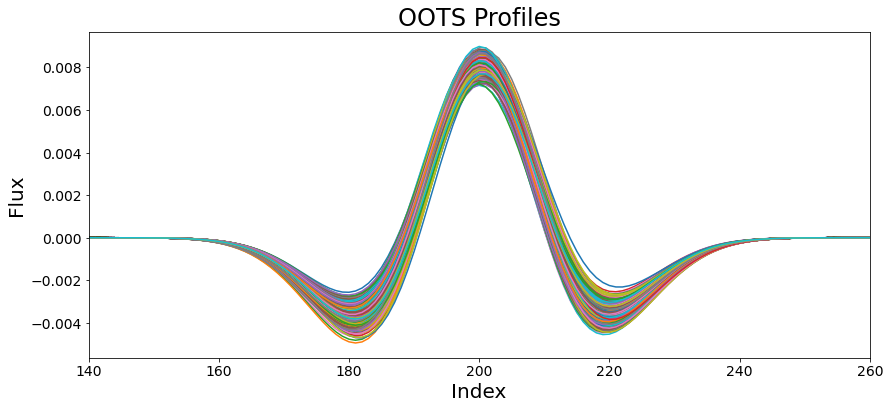

In [30]:
plt.figure(figsize=figsize)
for i in range(new_oots_profiles.shape[0]):
    plt.plot(new_oots_profiles[i])
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlim(140, 260)
plt.xlabel('Index', fontsize=labelsize)
plt.ylabel('Flux', fontsize=labelsize)
plt.title('OOTS Profiles', fontsize=titlesize)
plt.show()

In [31]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1000):
    x_p = 0
    y_p = 0
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 800000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles_1 = np.squeeze(intensities_list)

Time to generate 20 training profiles: 8.5 hours


In [34]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1):
    x_p = 5
    y_p = 5
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 800000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

new_oot_flux_profile_1 = np.squeeze(intensities_list)

Time to generate 20 training profiles: 0.01 hours


In [32]:
np.save('flux_profiles_1.npy', intensities_array)
loaded_flux_profiles_1 = np.load('flux_profiles_1.npy')

In [35]:
new_oots_profiles_1 = loaded_flux_profiles_1 - np.tile(new_oot_flux_profile_1, (loaded_flux_profiles_1.shape[0], 1))

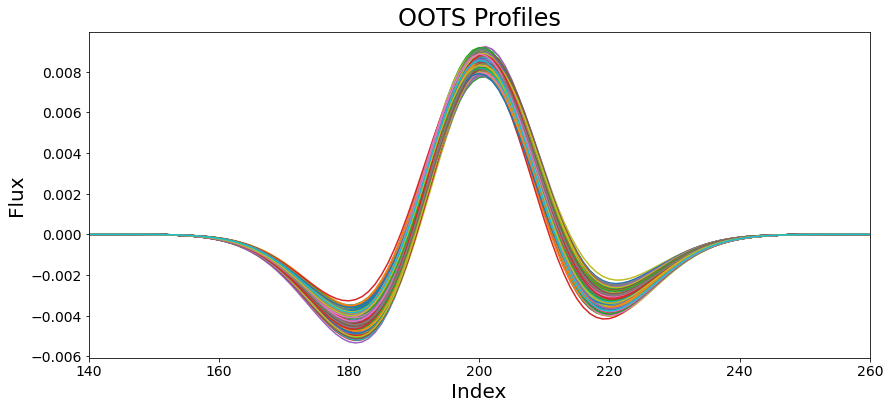

In [36]:
plt.figure(figsize=figsize)
for i in range(new_oots_profiles_1.shape[0]):
    plt.plot(new_oots_profiles_1[i])
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlim(140, 260)
plt.xlabel('Index', fontsize=labelsize)
plt.ylabel('Flux', fontsize=labelsize)
plt.title('OOTS Profiles', fontsize=titlesize)
plt.show()

In [37]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1000):
    x_p = 0
    y_p = 0
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 1000000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles_2 = np.squeeze(intensities_list)

Time to generate 20 training profiles: 10.91 hours


In [41]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(1):
    x_p = 5
    y_p = 5
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, 1000000)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

new_oot_flux_profile_2 = np.squeeze(intensities_list)

Time to generate 20 training profiles: 0.01 hours


In [39]:
np.save('flux_profiles_2.npy', intensities_array)
loaded_flux_profiles_2 = np.load('flux_profiles_2.npy')

In [42]:
new_oots_profiles_2 = loaded_flux_profiles_2 - np.tile(new_oot_flux_profile_2, (loaded_flux_profiles_2.shape[0], 1))

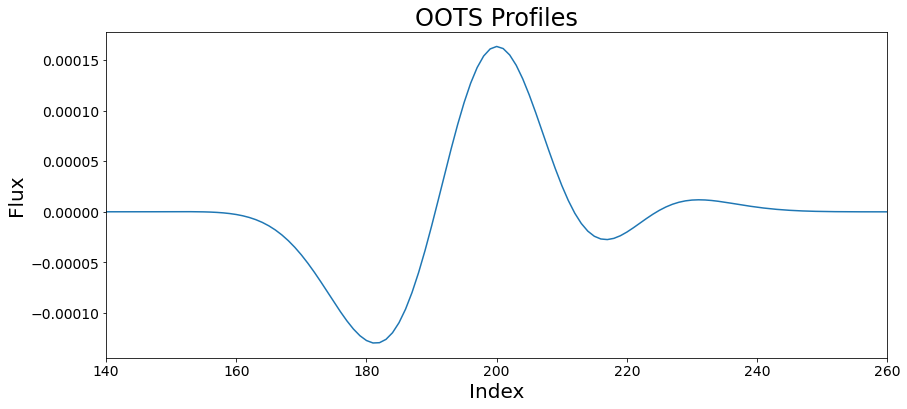

In [43]:
plt.figure(figsize=figsize)
for i in range(new_oots_profiles_2.shape[0]):
    plt.plot(new_oots_profiles_2[i])
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlim(140, 260)
plt.xlabel('Index', fontsize=labelsize)
plt.ylabel('Flux', fontsize=labelsize)
plt.title('OOTS Profiles', fontsize=titlesize)
plt.show()